In [38]:
# importing necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from itertools import product
import sklearn
plt.style.use('seaborn')

In [39]:
# getting Chicago SRW Wheat Futures Close price from yahoo finance and saving to dataframe
data = yf.download('ZW=F', start = '2006-01-01', end = '2022-06-04')['Close'].to_frame()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

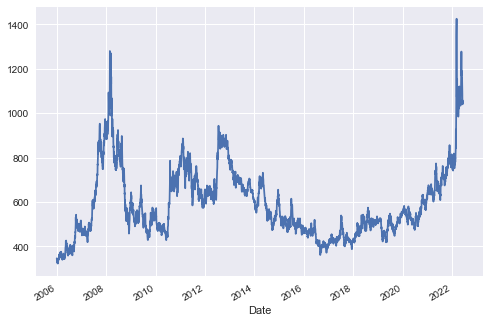

In [40]:
data.head()
data['Close'].plot()

In [41]:
# saving the dataframe as csv file
data.to_csv('wheat.csv')

In [42]:
dataset_train = pd.read_csv('wheat_train.csv')

training_set = dataset_train.iloc[:, 1:2].values
dataset1_train = dataset_train['close']

dataset_test = pd.read_csv('wheat_test.csv')
real_price = dataset_test.iloc[:, 1:2].values
dataset1_test = pd.read_csv('test.csv')


In [43]:
from sklearn.preprocessing import MinMaxScaler
# creating an object sc in minmaxscalar class. Normalising(Scaling) stock prices between 0 and 1
sc = MinMaxScaler(feature_range = (0,1))
# using fit_transform method for scaling training_set
training_set_scaled = sc.fit_transform(training_set)

In [44]:
# Creating empty lists for inputs to Neural Network (x_train) and output (y_train)
# for each day x_train will contain 60 previous day prices, and y_train will contan next day's predicted price
x_train = []
y_train = []
# populating these empty lists with a for loop. we need to start with the 61st observation to get 60 previous prices
# Total observations in training set are 3019
for i in range(60, 3019):
  x_train.append(training_set_scaled[i-60 : i, 0]) # choosing previous 60 observations in column 1 (We only have one column)
  y_train.append(training_set_scaled[i , 0])
# creating a numpy array with these lists
x_train, y_train = np.array(x_train), np.array(y_train)

In [45]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# selecting number of rows uisng [0] and number of columns using [1]. The 1 at the end is the number of predictors

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [47]:
regressor = Sequential()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-05 18:59:10.786808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-05 18:59:10.787194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [48]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))


In [49]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [50]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [51]:
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(0.2))

In [52]:
regressor.add(Dense(units = 1))

In [53]:
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

In [63]:
regressor.fit(x = x_train, y = y_train, batch_size = 16, epochs = 100 )

Epoch 1/100
 12/185 [>.............................] - ETA: 13s - loss: 3.1817e-04

KeyboardInterrupt: 

In [ ]:

dataset_total = pd.concat((dataset1_train, dataset1_test), axis = 0) # for vertical concatenation, axis = 0
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60 : ].values
# we are choosing 60 previous values from dataset_train for our prediction number 1
inputs = inputs.reshape(-1, 1) # this gets input for stock prices in 1 column
inputs = sc.transform(inputs) 
# scaling the inputs. do not need to use fit_transform because sc object was already fitted to training set
# scaling must be the same on which our regressor was trained

In [64]:
# we do not need y_test because we making predictions
# the test set contains 936 financial days so the upper bound in for loop would be 60+936 = 996
x_test = []
for i in range (60, 996):
  x_test.append(inputs[i-60 : i, 0])
x_test = np.array(x_test)
# creating a 3-d structure for keras
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_price = regressor.predict(x_test)

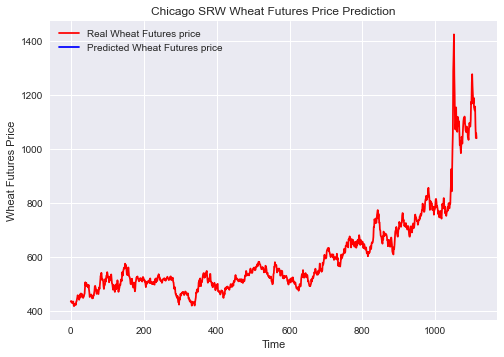

In [65]:
# plotting the real Chicago SRW Wheat Futures price
plt.plot(real_price, color = 'red', label = 'Real Wheat Futures price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Wheat Futures price')
plt.title('Chicago SRW Wheat Futures Price Prediction')
plt.xlabel('Time')
plt.ylabel('Wheat Futures Price')
plt.legend()
plt.show()